## Timeseries Forecasting with ARIMA

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import linregress, t
from pmdarima import auto_arima
import warnings

warnings.filterwarnings('ignore')

## Test Stationarity

In [134]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


## Data Preprocessing

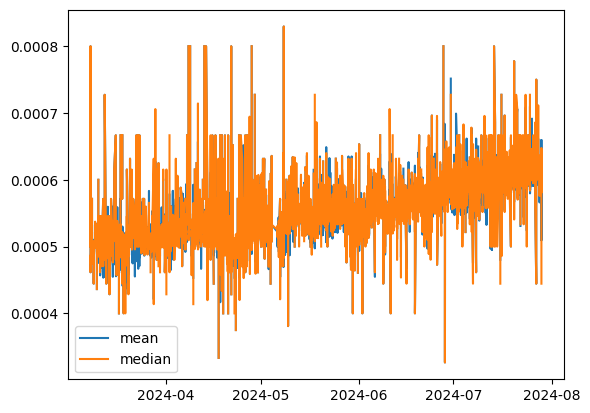

In [135]:
data = pd.read_csv("./new_data/reshaped.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

data['R_normal_mean'] = data[['R_normal_2', 'R_normal_3', 'R_normal_4', 'R_normal_5', 'R_normal_6', 'R_normal_8', 'R_normal_9', 'R_normal_10']].mean(axis=1)
data['R_normal_median'] = data[['R_normal_2', 'R_normal_3', 'R_normal_4', 'R_normal_5', 'R_normal_6', 'R_normal_8', 'R_normal_9', 'R_normal_10']].median(axis=1)
data['R_crimp_mean'] = data[['R_crimp_1', 'R_crimp_2', 'R_crimp_3', 'R_crimp_4', 'R_crimp_5']].mean(axis=1)
data['R_cross_mean'] = data[['R_cross_1', 'R_cross_2', 'R_cross_3', 'R_cross_4', 'R_cross_5']].mean(axis=1)
plt.plot(data['R_normal_mean'])
plt.plot(data['R_normal_median'])
plt.legend(['mean', 'median'])
#plt.plot(data['R_crimp_mean'])
#lt.plot(data['R_cross_mean'])

ts = data['R_normal_mean']
ts_crimp = data['R_crimp_mean']
ts_cross = data['R_cross_mean']

## Making data stationary

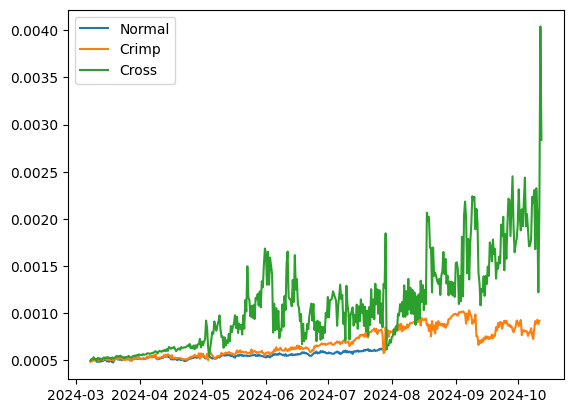

In [136]:
ts_resampled = ts.resample('12h').mean().dropna()
ts_resampled_crimp = ts_crimp.resample('12h').mean().dropna()
ts_resampled_cross = ts_cross.resample('12h').mean().dropna()

plt.plot(ts_resampled)
plt.plot(ts_resampled_crimp)
plt.plot(ts_resampled_cross)
plt.legend(['Normal', 'Crimp', 'Cross'])
plt.show()

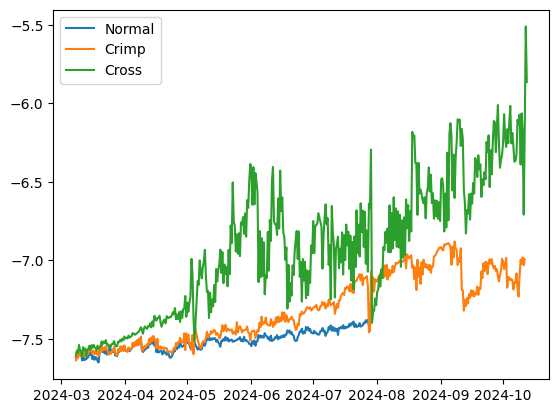

In [137]:
ts_resampled_log = np.log(ts_resampled)
ts_resampled_crimp_log = np.log(ts_resampled_crimp)
ts_resampled_cross_log = np.log(ts_resampled_cross)

plt.plot(ts_resampled_log)
plt.plot(ts_resampled_crimp_log)
plt.plot(ts_resampled_cross_log)
plt.legend(['Normal', 'Crimp', 'Cross'])
plt.show()


In [138]:
# tf_moving_avg = ts_resampled_log.rolling(window=14).mean()
# plt.plot(tf_moving_avg)

**Moving Average**

In [139]:
# ts_resampled_log_moving_avg_diff = ts_resampled_log - tf_moving_avg
# ts_resampled_log_moving_avg_diff.dropna(inplace=True)
# plt.plot(ts_resampled_log_moving_avg_diff)

In [140]:
# test_stationarity(ts_resampled_log_moving_avg_diff)

**Exponential Weighted Average**

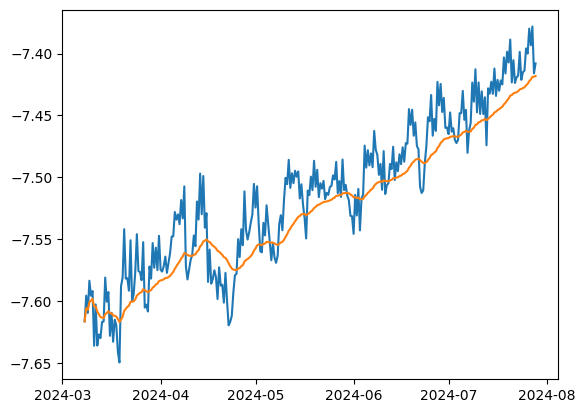

In [141]:
exp_weighted_avg = ts_resampled_log.ewm(halflife=14, min_periods=0, adjust=True).mean()
plt.plot(ts_resampled_log)
plt.plot(exp_weighted_avg)


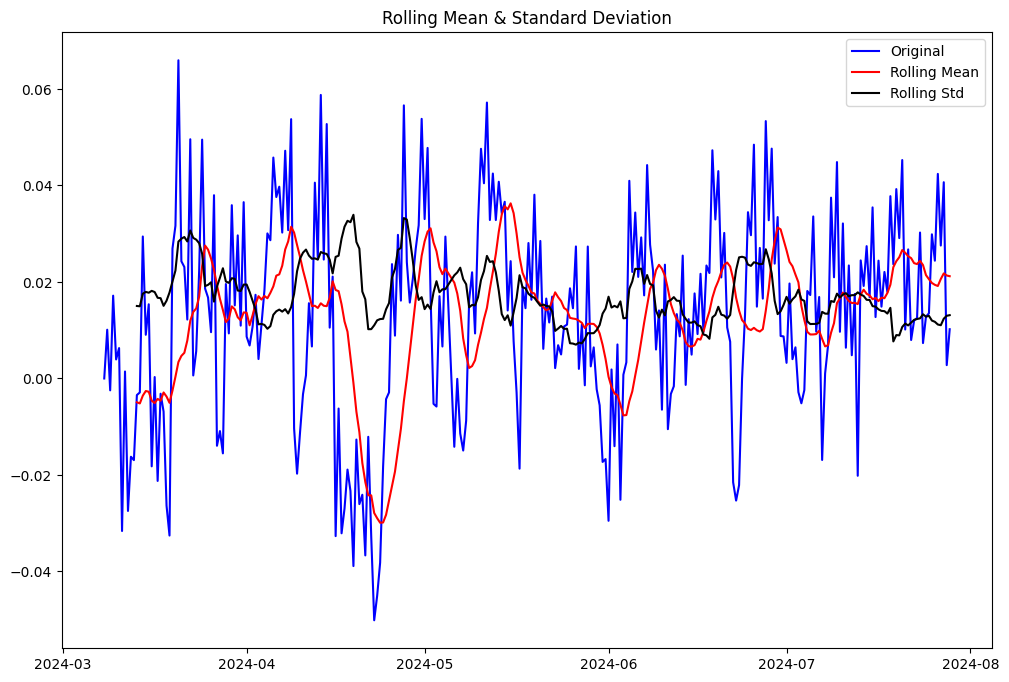

Results of Dickey-Fuller Test:
Test Statistic                  -4.282473
p-value                          0.000476
#Lags Used                      12.000000
Number of Observations Used    271.000000
Critical Value (1%)             -3.454713
Critical Value (5%)             -2.872265
Critical Value (10%)            -2.572485
dtype: float64


In [142]:
ts_resampled_log_ewma_diff = ts_resampled_log - exp_weighted_avg
test_stationarity(ts_resampled_log_ewma_diff)

**Log Shift**

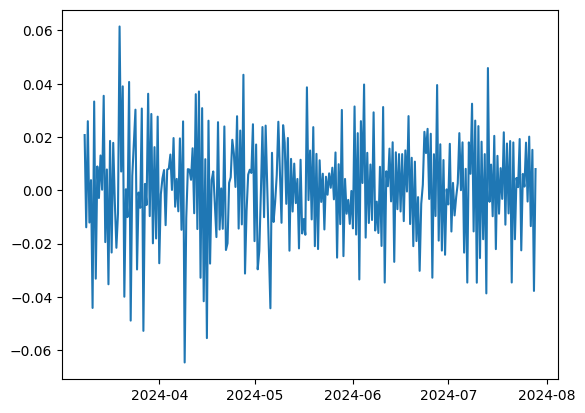

In [143]:
ts_log_diff = ts_resampled_log - ts_resampled_log.shift()
plt.plot(ts_log_diff)

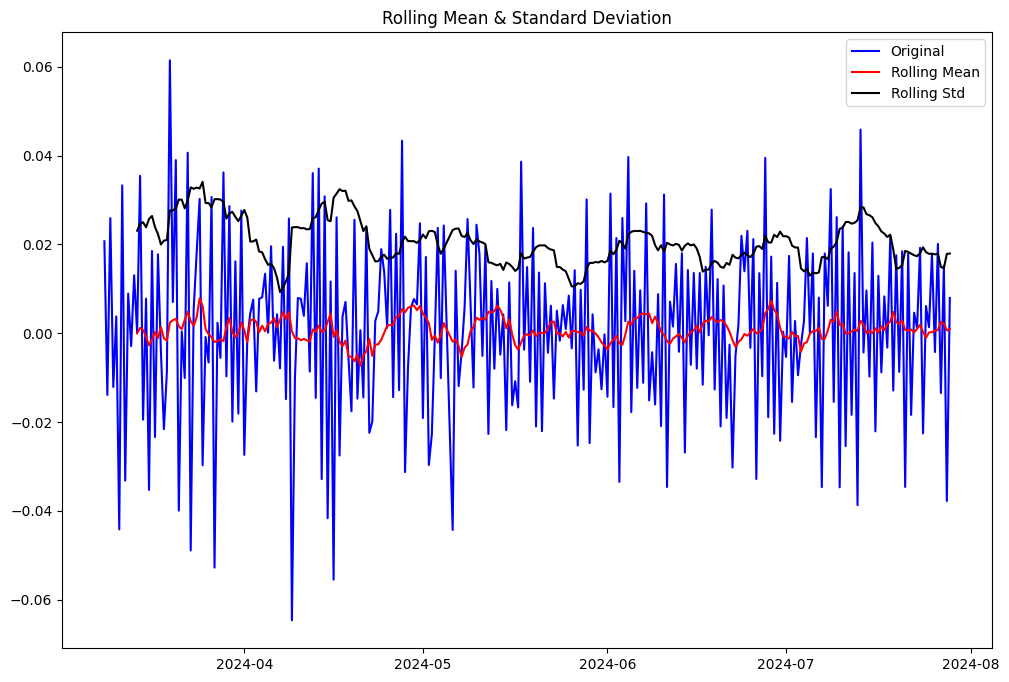

Results of Dickey-Fuller Test:
Test Statistic                -6.182213e+00
p-value                        6.414459e-08
#Lags Used                     1.600000e+01
Number of Observations Used    2.660000e+02
Critical Value (1%)           -3.455175e+00
Critical Value (5%)           -2.872468e+00
Critical Value (10%)          -2.572593e+00
dtype: float64


In [144]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Decomposition

**Normal**

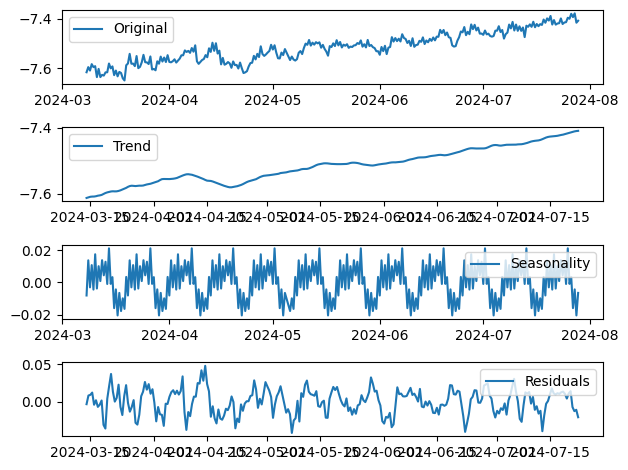

In [145]:
decomposition = seasonal_decompose(ts_resampled_log, model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_resampled_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

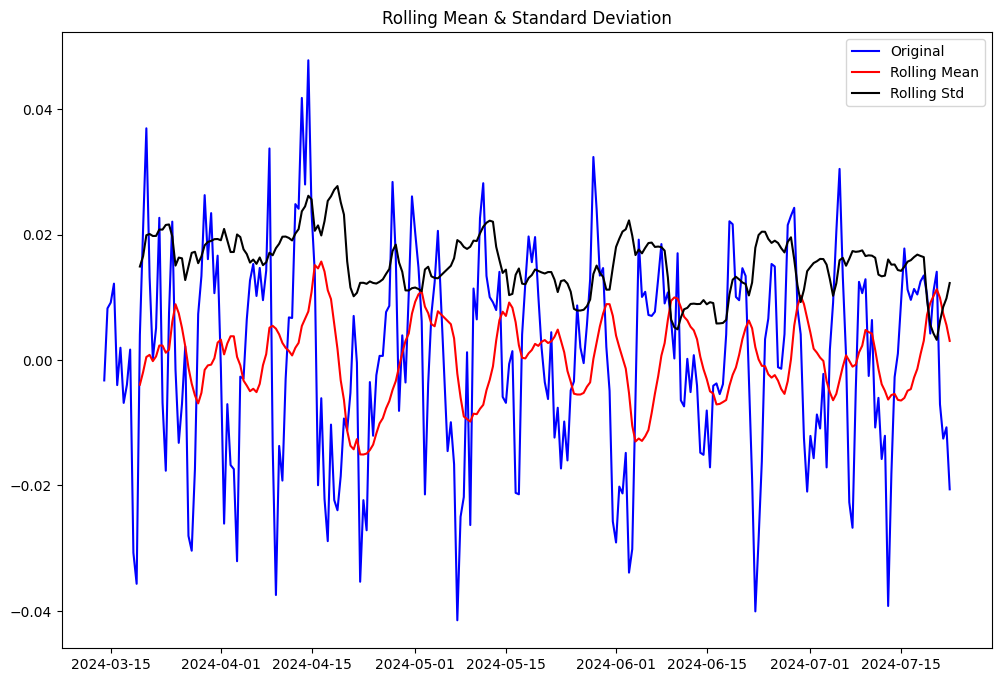

Results of Dickey-Fuller Test:
Test Statistic                -7.661911e+00
p-value                        1.679925e-11
#Lags Used                     9.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


In [146]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

**Bad Crimped**

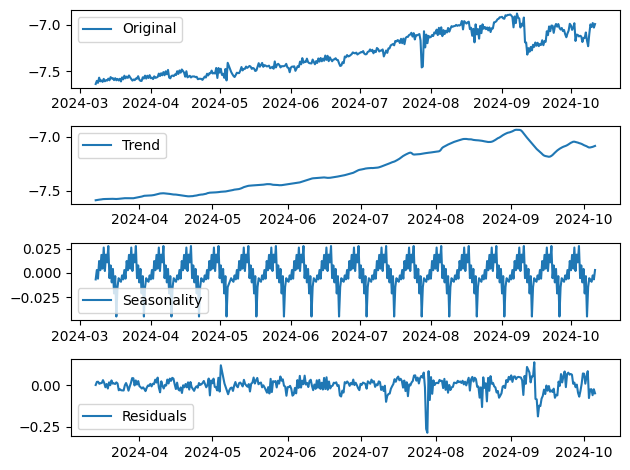

In [147]:
decomposition_crimp = seasonal_decompose(ts_resampled_crimp_log, model='additive', period=24)
trend_crimp = decomposition_crimp.trend
seasonal_crimp = decomposition_crimp.seasonal
residual_crimp = decomposition_crimp.resid
plt.subplot(411)
plt.plot(ts_resampled_crimp_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_crimp, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_crimp, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_crimp, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

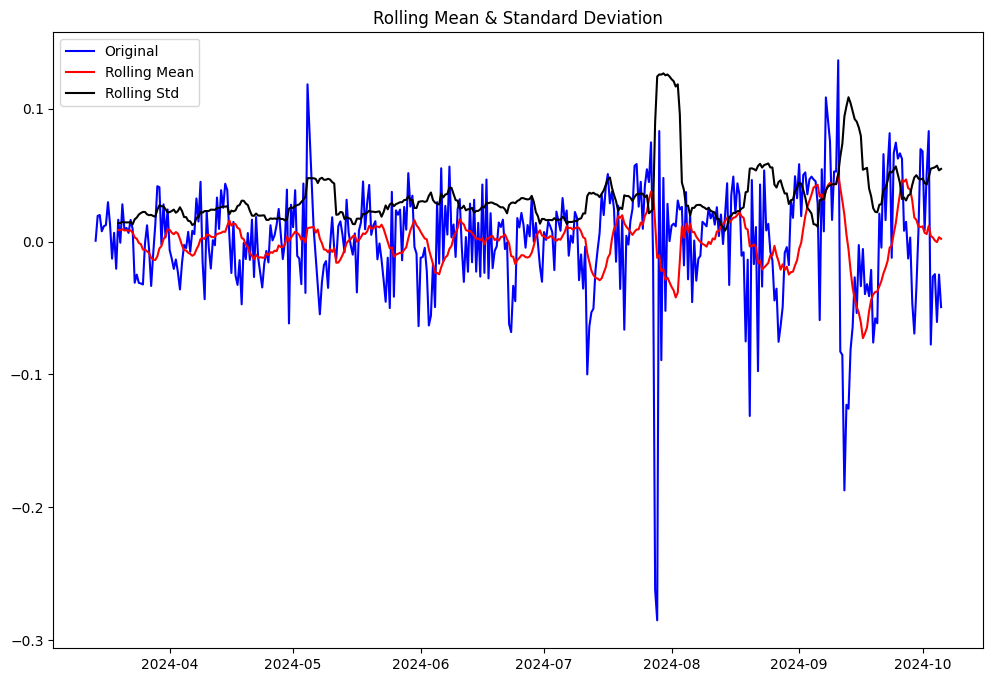

Results of Dickey-Fuller Test:
Test Statistic                -7.867818e+00
p-value                        5.078847e-12
#Lags Used                     6.000000e+00
Number of Observations Used    4.030000e+02
Critical Value (1%)           -3.446681e+00
Critical Value (5%)           -2.868739e+00
Critical Value (10%)          -2.570605e+00
dtype: float64


In [148]:
ts_log_decompose_crimp = residual_crimp
ts_log_decompose_crimp.dropna(inplace=True)
test_stationarity(ts_log_decompose_crimp)

**Cross-Mated**

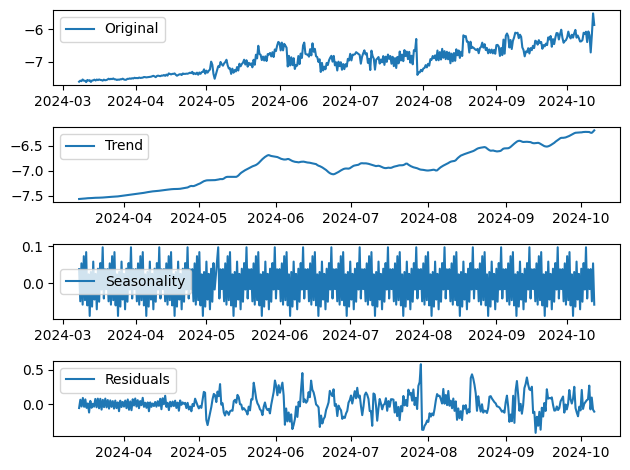

In [149]:
decomposition_cross = seasonal_decompose(ts_resampled_cross_log, model='additive', period=24)
trend_cross = decomposition_cross.trend
seasonal_cross = decomposition_cross.seasonal
residual_cross = decomposition_cross.resid
plt.subplot(411)
plt.plot(ts_resampled_cross_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cross, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cross, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cross, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

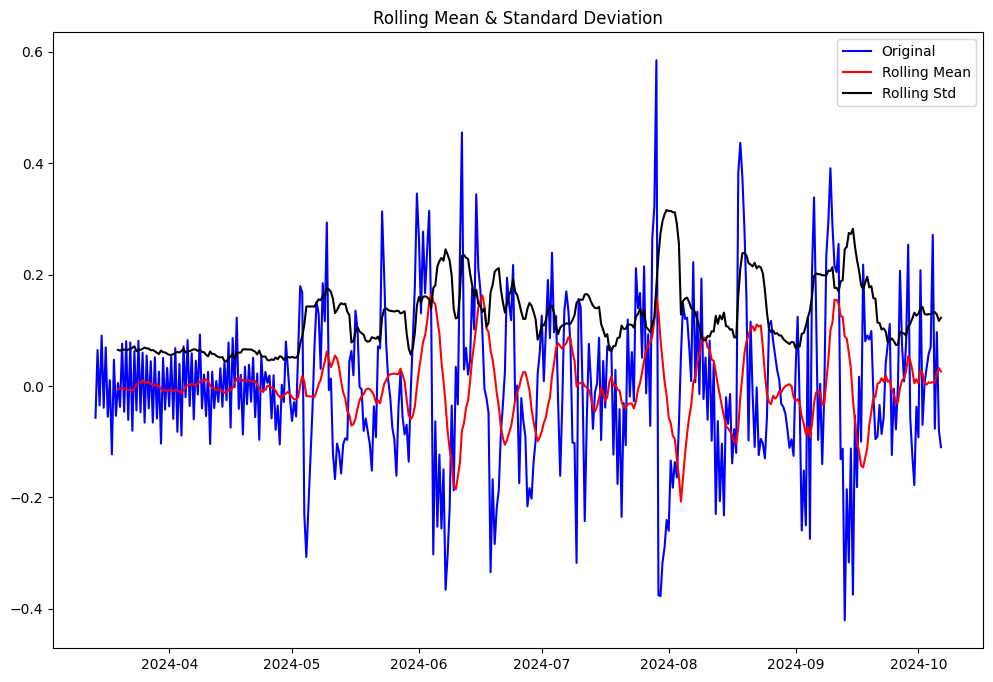

Results of Dickey-Fuller Test:
Test Statistic                -7.970887e+00
p-value                        2.783357e-12
#Lags Used                     1.600000e+01
Number of Observations Used    3.950000e+02
Critical Value (1%)           -3.447014e+00
Critical Value (5%)           -2.868885e+00
Critical Value (10%)          -2.570683e+00
dtype: float64


In [150]:
ts_log_decompose_cross = residual_cross
ts_log_decompose_cross.dropna(inplace=True)
test_stationarity(ts_log_decompose_cross)

## Final Forecasting

Text(0.5, 1.0, 'Partial Autocorrelation Function')

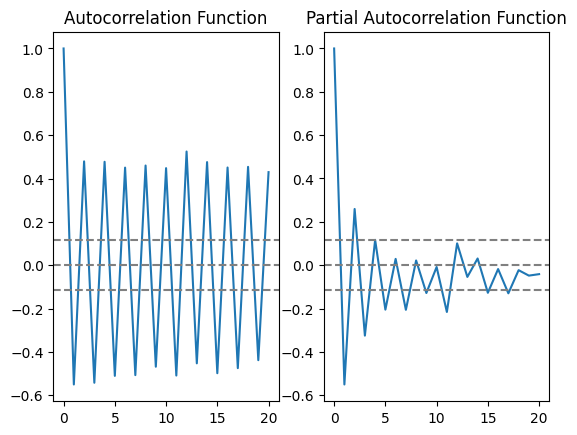

In [151]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')


## Calculate best Components

In [152]:
ts_resampled_log.head()

datetime
2024-03-08 00:00:00   -7.616045
2024-03-08 12:00:00   -7.595318
2024-03-09 00:00:00   -7.609206
2024-03-09 12:00:00   -7.583274
2024-03-10 00:00:00   -7.595374
Name: R_normal_mean, dtype: float64

**SARIMA Model Normal**

In [153]:
model = auto_arima(ts_resampled_log,  # Data
                   seasonal=True,   # Enable seasonal modeling
                   m=12,            # Specify seasonal period (e.g., 12 for monthly data)
                   start_p=0, max_p=3,  # Non-seasonal AR terms
                   start_q=0, max_q=3,  # Non-seasonal MA terms
                   d=None,          # Automatically detect differencing order
                   start_P=0, max_P=2,  # Seasonal AR terms
                   start_Q=0, max_Q=2,  # Seasonal MA terms
                   D=None,          # Automatically detect seasonal differencing
                   trace=True,      # Print progress
                   error_action='ignore', # Ignore convergence errors
                   suppress_warnings=True, # Suppress warnings
                   stepwise=True)   # Use stepwise search for faster performance

# Summary of the best-fit SARIMA model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1392.474, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1511.254, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1488.142, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1394.111, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1492.657, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-1513.968, Time=0.68 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-1536.469, Time=1.24 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1528.295, Time=0.36 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-1545.847, Time=1.10 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-1535.204, Time=0.92 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=-1541.564, Time=1.53 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,1)(2,0,2)[12

**SARIMA Model Crimp**

In [154]:
model_crimp = auto_arima(ts_resampled_crimp_log,  # Data
                   seasonal=True,   # Enable seasonal modeling
                   m=12,            # Specify seasonal period (e.g., 12 for monthly data)
                   start_p=0, max_p=3,  # Non-seasonal AR terms
                   start_q=0, max_q=3,  # Non-seasonal MA terms
                   d=None,          # Automatically detect differencing order
                   start_P=0, max_P=2,  # Seasonal AR terms
                   start_Q=0, max_Q=2,  # Seasonal MA terms
                   D=None,          # Automatically detect seasonal differencing
                   trace=True,      # Print progress
                   error_action='ignore', # Ignore convergence errors
                   suppress_warnings=True, # Suppress warnings
                   stepwise=True)   # Use stepwise search for faster performance

# Summary of the best-fit SARIMA model
print(model_crimp.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1329.270, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1465.242, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1446.141, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1330.916, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1466.956, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-1465.209, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1462.957, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-1465.384, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-1466.910, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1448.110, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-1473.095, Time=0.39 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-1467.428, Time=0.65 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-1466.099, Time=0.65 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=-1468.044, Time=1.00 sec
 ARIM

**SARIMA Model Cross-Mated**

In [155]:
model_cross = auto_arima(ts_resampled_cross_log,  # Data
                   seasonal=True,   # Enable seasonal modeling
                   m=12,            # Specify seasonal period (e.g., 12 for monthly data)
                   start_p=0, max_p=3,  # Non-seasonal AR terms
                   start_q=0, max_q=3,  # Non-seasonal MA terms
                   d=None,          # Automatically detect differencing order
                   start_P=0, max_P=3,  # Seasonal AR terms
                   start_Q=0, max_Q=3,  # Seasonal MA terms
                   D=None,          # Automatically detect seasonal differencing
                   trace=True,      # Print progress
                   error_action='ignore', # Ignore convergence errors
                   suppress_warnings=True, # Suppress warnings
                   stepwise=True)   # Use stepwise search for faster performance

# Summary of the best-fit SARIMA model
print(model_cross.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-229.549, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-410.721, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-384.803, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-231.346, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-407.019, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-418.686, Time=0.51 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=-438.850, Time=1.14 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=-443.239, Time=2.30 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-441.969, Time=1.03 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=-441.336, Time=2.84 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-438.591, Time=1.63 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=-397.153, Time=1.72 sec
 ARIMA(2,1,0)(3,0,1)[12] intercept   : AIC=-441.253, Time=2.73 sec
 ARIMA(1,1,1)(3,0,1)[12] intercept   : AIC=-463.095, Time=2.63 sec
 ARIMA(1,1,1)(2,0,1

**Creating Model for Normal**

                                        SARIMAX Results                                        
Dep. Variable:                           R_normal_mean   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                 786.486
Date:                                 Mon, 02 Dec 2024   AIC                          -1560.972
Time:                                         13:33:42   BIC                          -1539.099
Sample:                                              0   HQIC                         -1552.202
                                                 - 284                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1299      0.054     -2.423      0.015      -0.235      -0

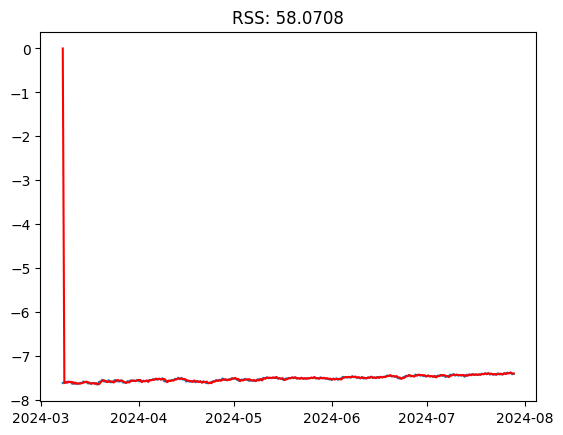

In [156]:
model = SARIMAX(ts_resampled_log, order=(1, 1, 0), seasonal_order=(2, 0, 2, 12))
results_SARIMA = model.fit()
plt.plot(ts_resampled_log)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_SARIMA.fittedvalues-ts_resampled_log)**2))
print(results_SARIMA.summary())


**Creating Model for Crimp**

                                        SARIMAX Results                                        
Dep. Variable:                            R_crimp_mean   No. Observations:                  434
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood                 682.513
Date:                                 Mon, 02 Dec 2024   AIC                          -1357.025
Time:                                         13:33:43   BIC                          -1340.742
Sample:                                              0   HQIC                         -1350.597
                                                 - 434                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7884      0.090      8.734      0.000       0.612       0

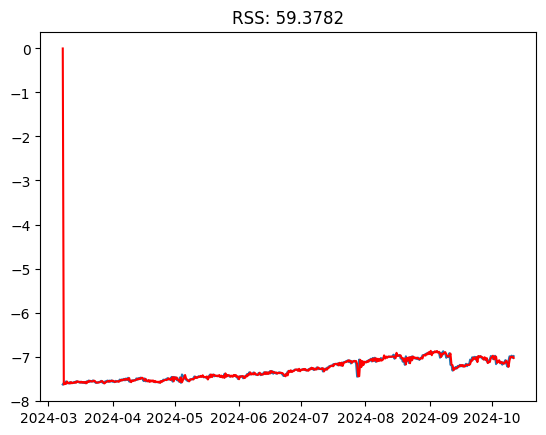

In [157]:
model_crimp = SARIMAX(ts_resampled_crimp_log, order=(0, 1, 0), seasonal_order=(1, 0, 2, 12))
results_SARIMA_crimp = model_crimp.fit()
plt.plot(ts_resampled_crimp_log)
plt.plot(results_SARIMA_crimp.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_SARIMA_crimp.fittedvalues-ts_resampled_crimp_log)**2))
print(results_SARIMA_crimp.summary())

**Creating Model for Cross-Mated**

                                        SARIMAX Results                                        
Dep. Variable:                            R_cross_mean   No. Observations:                  436
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 228.457
Date:                                 Mon, 02 Dec 2024   AIC                           -446.915
Time:                                         13:33:44   BIC                           -426.538
Sample:                                              0   HQIC                          -438.872
                                                 - 436                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4040      0.032    -12.719      0.000      -0.466      -0

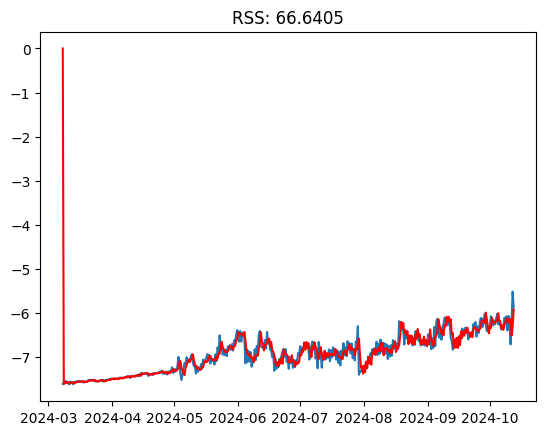

In [158]:
model_cross = SARIMAX(ts_resampled_cross_log, order=(0, 1, 1), seasonal_order=(1, 0, 2, 12))
results_SARIMA_cross = model_cross.fit()
plt.plot(ts_resampled_cross_log)
plt.plot(results_SARIMA_cross.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_SARIMA_cross.fittedvalues-ts_resampled_cross_log)**2))
print(results_SARIMA_cross.summary())

Number of points with residuals exceeding the threshold (Normal; Crimp; Cross): 1; 1; 6


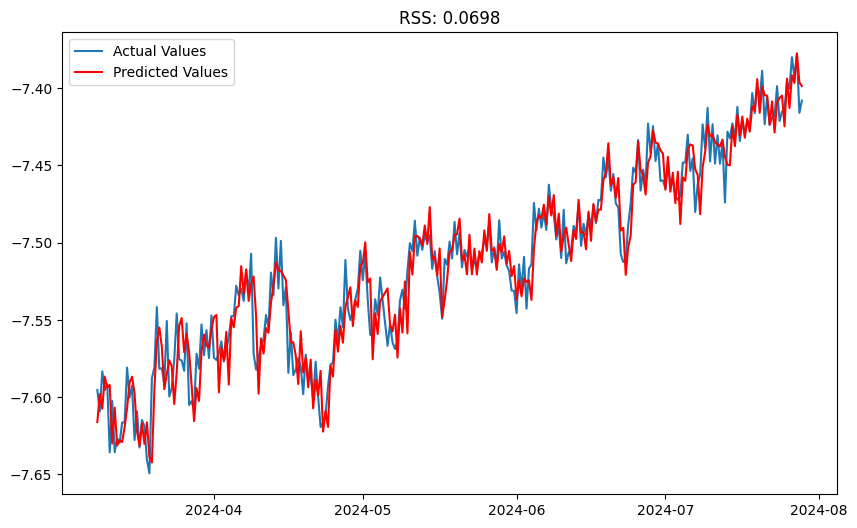

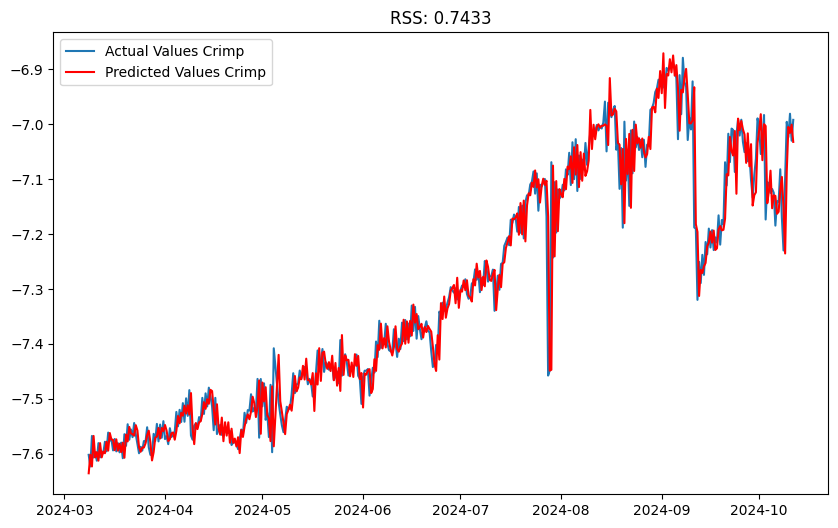

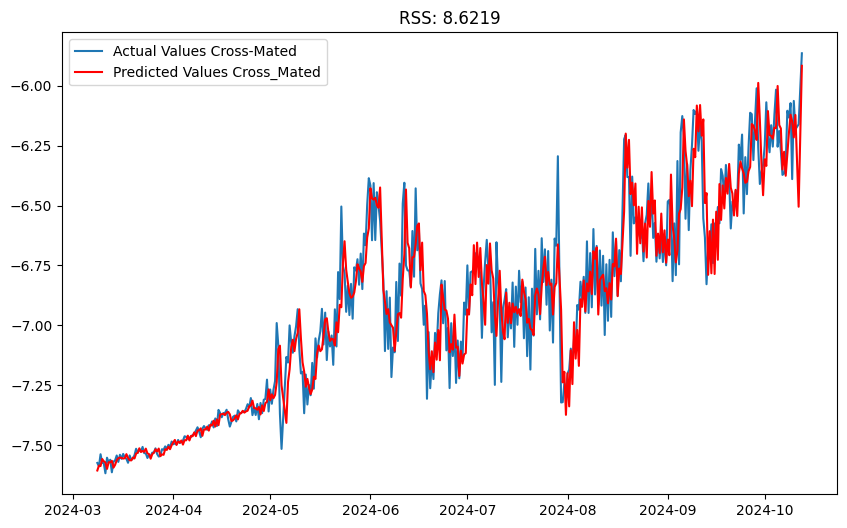

In [159]:
import matplotlib.pyplot as plt

residuals = results_SARIMA.fittedvalues - ts_resampled_log
residuals_crimp = results_SARIMA_crimp.fittedvalues - ts_resampled_crimp_log
residuals_cross = results_SARIMA_cross.fittedvalues - ts_resampled_cross_log

threshold = 0.5 
mask = abs(residuals) < threshold
mask_crimp = abs(residuals_crimp) < threshold
mask_cross = abs(residuals_cross) < threshold


subset_actual = ts_resampled_log[mask]
subset_predicted = results_SARIMA.fittedvalues[mask]

subset_actual_crimp = ts_resampled_crimp_log[mask_crimp]
subset_predicted_crimp = results_SARIMA_crimp.fittedvalues[mask_crimp]

subset_actual_cross = ts_resampled_cross_log[mask_cross]
subset_predicted_cross = results_SARIMA_cross.fittedvalues[mask_cross]

exceeds_threshold = sum(abs(residuals) > threshold)
exceeds_threshold_crimp = sum(abs(residuals_crimp) > threshold)
exceeds_threshold_cross = sum(abs(residuals_cross) > threshold)

print(f'Number of points with residuals exceeding the threshold (Normal; Crimp; Cross): {exceeds_threshold}; {exceeds_threshold_crimp}; {exceeds_threshold_cross}')

plt.figure(figsize=(10,6))
plt.plot(subset_actual, label='Actual Values')
plt.plot(subset_predicted, label='Predicted Values', color='red')
plt.title('RSS: %.4f' % sum((residual)**2))
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(subset_actual_crimp, label='Actual Values Crimp')
plt.plot(subset_predicted_crimp, label='Predicted Values Crimp', color='red')
plt.title('RSS: %.4f' % sum((residual_crimp)**2))
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(subset_actual_cross, label='Actual Values Cross-Mated')
plt.plot(subset_predicted_cross, label='Predicted Values Cross_Mated', color='red')
plt.title('RSS: %.4f' % sum((residual_cross)**2))
plt.legend()
plt.show()


## Convert to Original Scale

datetime
2024-03-08 12:00:00   -7.616045
2024-03-09 00:00:00   -7.598010
2024-03-09 12:00:00   -7.607402
2024-03-10 00:00:00   -7.586643
2024-03-10 12:00:00   -7.593802
dtype: float64
datetime
2024-03-08 12:00:00   -7.635395
2024-03-09 00:00:00   -7.601811
2024-03-09 12:00:00   -7.622983
2024-03-10 00:00:00   -7.567465
2024-03-10 12:00:00   -7.606664
dtype: float64
datetime
2024-03-08 12:00:00   -7.605315
2024-03-09 00:00:00   -7.584788
2024-03-09 12:00:00   -7.586804
2024-03-10 00:00:00   -7.557406
2024-03-10 12:00:00   -7.566877
dtype: float64


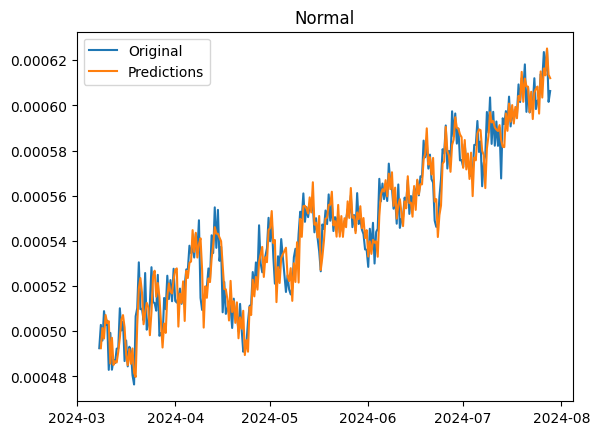

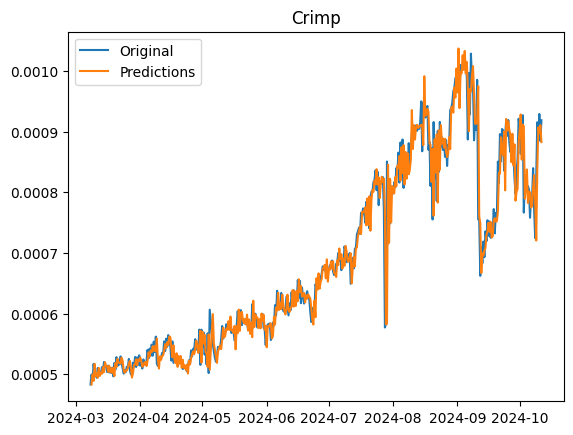

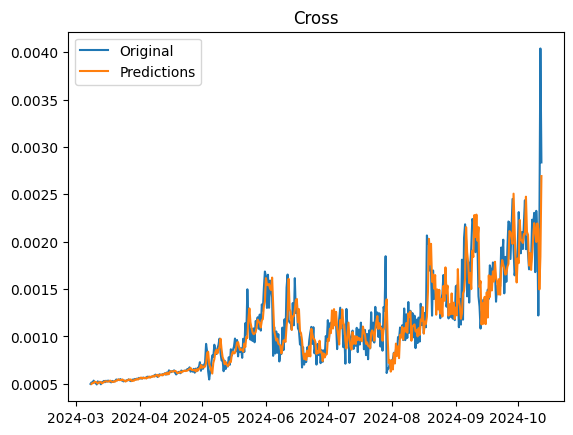

In [160]:
predictions_SARIMA = pd.Series(results_SARIMA.fittedvalues, copy=True)
predictions_SARIMA = predictions_SARIMA[1:]
print(predictions_SARIMA.head())

predictions_SARIMA_crimp = pd.Series(results_SARIMA_crimp.fittedvalues, copy=True)
predictions_SARIMA_crimp = predictions_SARIMA_crimp[1:]
print(predictions_SARIMA_crimp.head())

predictions_SARIMA_cross = pd.Series(results_SARIMA_cross.fittedvalues, copy=True)
predictions_SARIMA_cross = predictions_SARIMA_cross[1:]
print(predictions_SARIMA_cross.head())

predictions_SARIMA = np.exp(predictions_SARIMA)
predictions_SARIMA_crimp = np.exp(predictions_SARIMA_crimp)
predictions_SARIMA_cross = np.exp(predictions_SARIMA_cross)

plt.title('Normal')
plt.plot(ts_resampled, label='Original')
plt.plot(predictions_SARIMA, label='Predictions')
plt.legend()
plt.show()

plt.title('Crimp')
plt.plot(ts_resampled_crimp, label='Original')
plt.plot(predictions_SARIMA_crimp, label='Predictions')
plt.legend()
plt.show()

plt.title('Cross')
plt.plot(ts_resampled_cross, label='Original')
plt.plot(predictions_SARIMA_cross, label='Predictions')
plt.legend()
plt.show()


test1 2024-10-12 12:00:00   -6.983889
2024-10-13 12:00:00   -6.958807
2024-10-14 12:00:00   -6.973228
2024-10-15 12:00:00   -6.971251
2024-10-16 12:00:00   -6.974093
Freq: D, Name: predicted_mean, dtype: float64
test2 2024-10-12 12:00:00    0.000927
2024-10-13 12:00:00    0.000950
2024-10-14 12:00:00    0.000937
2024-10-15 12:00:00    0.000938
2024-10-16 12:00:00    0.000936
Freq: D, Name: predicted_mean, dtype: float64


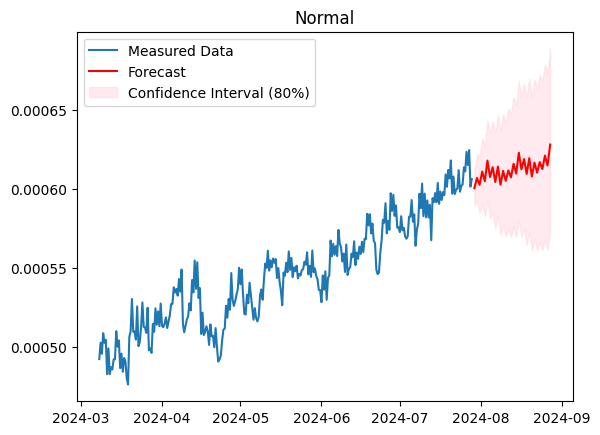

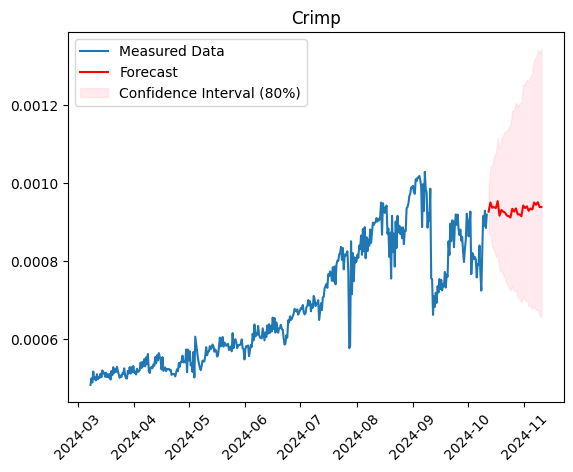

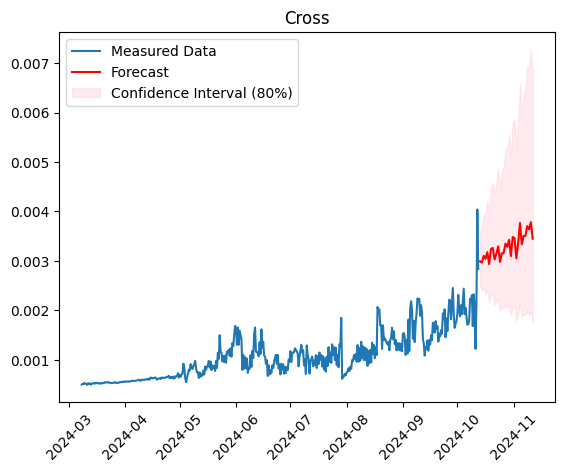

In [161]:
forecast_steps =30

forecast = results_SARIMA.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.2)

forecast_crimp = results_SARIMA_crimp.get_forecast(steps=forecast_steps)
forecast_mean_crimp = forecast_crimp.predicted_mean
forecast_ci_crimp = forecast_crimp.conf_int(alpha=0.2)

forecast_cross = results_SARIMA_cross.get_forecast(steps=forecast_steps)
forecast_mean_cross = forecast_cross.predicted_mean
forecast_ci_cross = forecast_cross.conf_int(alpha=0.2)

forecast_index = pd.date_range(start=ts_resampled.index[-1], periods=forecast_steps+1, freq='D')[1:]
forecast_index_crimp = pd.date_range(start=ts_resampled_crimp.index[-1], periods=forecast_steps+1, freq='D')[1:]
forecast_index_cross = pd.date_range(start=ts_resampled_cross.index[-1], periods=forecast_steps+1, freq='D')[1:]

forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

forecast_mean_crimp.index = forecast_index_crimp
forecast_ci_crimp.index = forecast_index_crimp

forecast_mean_cross.index = forecast_index_cross
forecast_ci_cross.index = forecast_index_cross

forecast_mean_original = np.exp(forecast_mean)
forecast_ci_original = np.exp(forecast_ci)

print("test1", forecast_mean_crimp.head())
forecast_mean_original_crimp = np.exp(forecast_mean_crimp)
forecast_ci_original_crimp = np.exp(forecast_ci_crimp)
print("test2", forecast_mean_original_crimp.head())

forecast_mean_original_cross = np.exp(forecast_mean_cross)
forecast_ci_original_cross = np.exp(forecast_ci_cross)

plt.title('Normal')
plt.plot(ts_resampled.index, ts_resampled, label='Measured Data')
plt.plot(forecast_mean_original.index, forecast_mean_original, color='red', label='Forecast')
plt.fill_between(forecast_ci_original.index, forecast_ci_original.iloc[:, 0], forecast_ci_original.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval (80%)')
plt.legend()
plt.show()

plt.title('Crimp')
plt.plot(ts_resampled_crimp.index, ts_resampled_crimp, label='Measured Data')
plt.plot(forecast_mean_original_crimp.index, forecast_mean_original_crimp, color='red', label='Forecast')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.fill_between(forecast_ci_original_crimp.index, forecast_ci_original_crimp.iloc[:, 0], forecast_ci_original_crimp.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval (80%)')
plt.legend()
plt.show()

plt.title('Cross')
plt.plot(ts_resampled_cross.index, ts_resampled_cross, label='Measured Data')
plt.plot(forecast_mean_original_cross.index, forecast_mean_original_cross, color='red', label='Forecast')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.fill_between(forecast_ci_original_cross.index, forecast_ci_original_cross.iloc[:, 0], forecast_ci_original_cross.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval (80%)')
plt.legend()
plt.show()


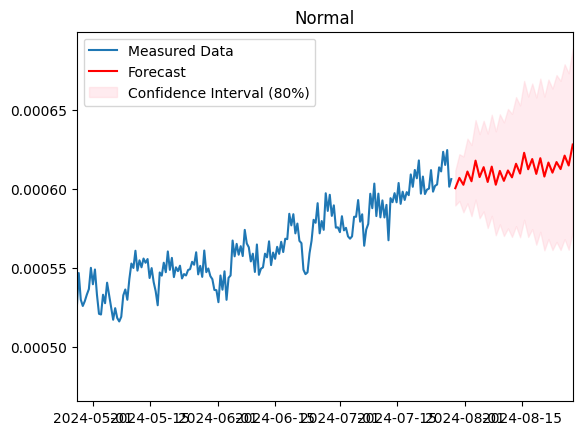

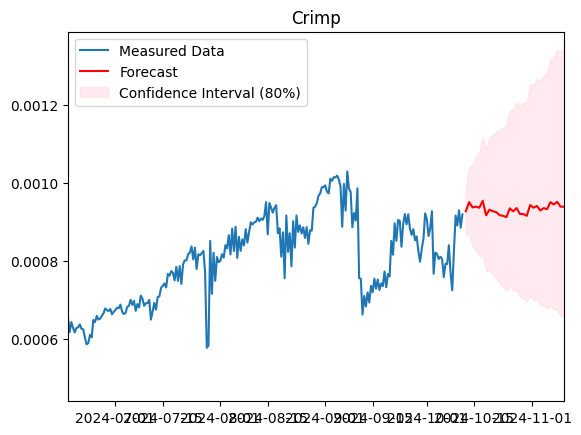

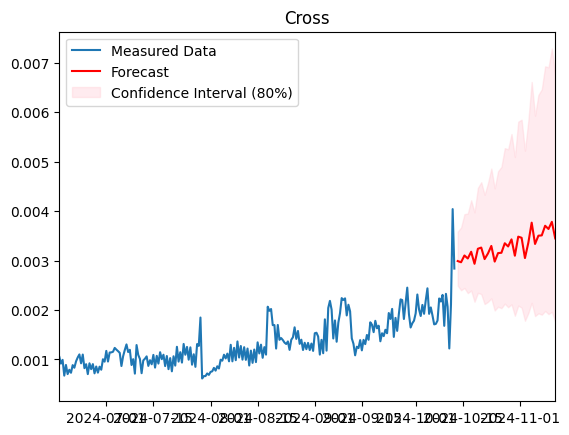

In [162]:
plt.title('Normal')
plt.plot(ts_resampled.index, ts_resampled, label='Measured Data')
plt.plot(forecast_mean_original.index, forecast_mean_original, color='red', label='Forecast')
plt.fill_between(forecast_ci_original.index, forecast_ci_original.iloc[:, 0], forecast_ci_original.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval (80%)')
plt.xlim(ts_resampled.index[100], forecast_mean_original.index[-1])
plt.legend()
plt.show()

plt.title('Crimp')
plt.plot(ts_resampled_crimp.index, ts_resampled_crimp, label='Measured Data')
plt.plot(forecast_mean_original_crimp.index, forecast_mean_original_crimp, color='red', label='Forecast')
plt.fill_between(forecast_ci_original_crimp.index, forecast_ci_original_crimp.iloc[:, 0], forecast_ci_original_crimp.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval (80%)')
plt.xlim(ts_resampled_crimp.index[200], forecast_mean_original_crimp.index[-1])
plt.legend()
plt.show()

plt.title('Cross')
plt.plot(ts_resampled_cross.index, ts_resampled_cross, label='Measured Data')
plt.plot(forecast_mean_original_cross.index, forecast_mean_original_cross, color='red', label='Forecast')
plt.fill_between(forecast_ci_original_cross.index, forecast_ci_original_cross.iloc[:, 0], forecast_ci_original_cross.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval (80%)')
plt.xlim(ts_resampled_cross.index[200], forecast_mean_original_cross.index[-1])
plt.legend()
plt.show()



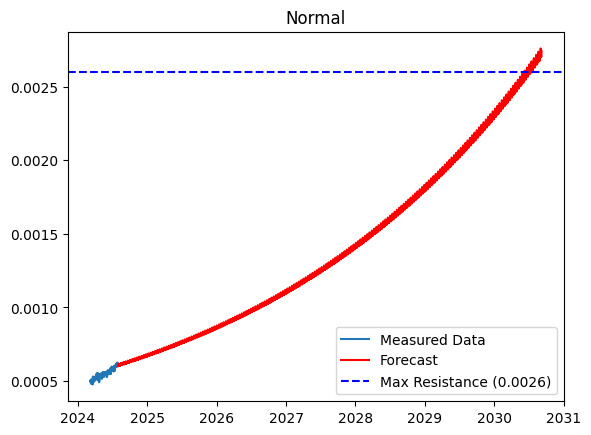

The date when the resistance level of 0.0026 is reached is 2030-09-05 12:00:00


In [163]:
forecast_steps = 30
max_resistance = 0.0026

while forecast_mean_original[-1] < max_resistance:
    forecast = results_SARIMA.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=0.05)

    forecast_index = pd.date_range(start=ts_resampled.index[-1], periods=forecast_steps+1, freq='D')[1:]

    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index

    forecast_mean_original = np.exp(forecast_mean)
    forecast_ci_original = np.exp(forecast_ci)
    forecast_steps += 100

plt.title('Normal')
plt.plot(ts_resampled.index, ts_resampled, label='Measured Data')
plt.plot(forecast_mean_original.index, forecast_mean_original, color='red', label='Forecast')
plt.axhline(y=max_resistance, color='blue', linestyle='--', linewidth=1.5, label='Max Resistance (0.0026)')
plt.legend()
plt.show()

print(f"The date when the resistance level of {max_resistance} is reached is {forecast_mean_original.index[-1]}")

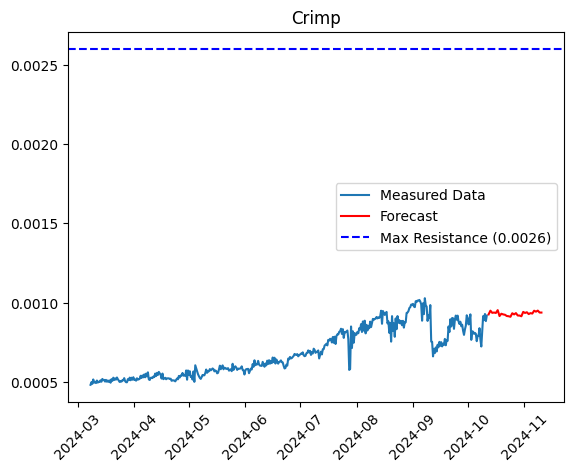

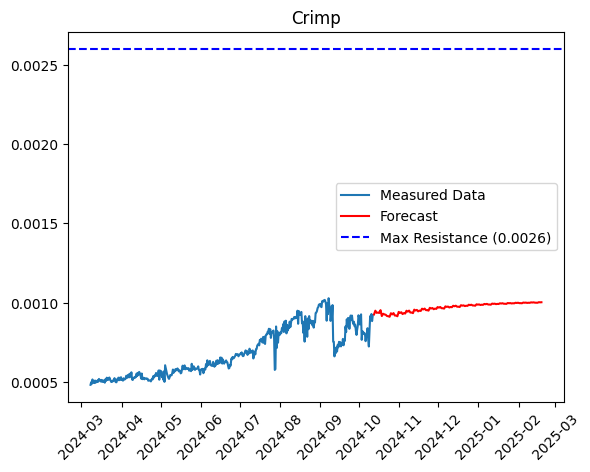

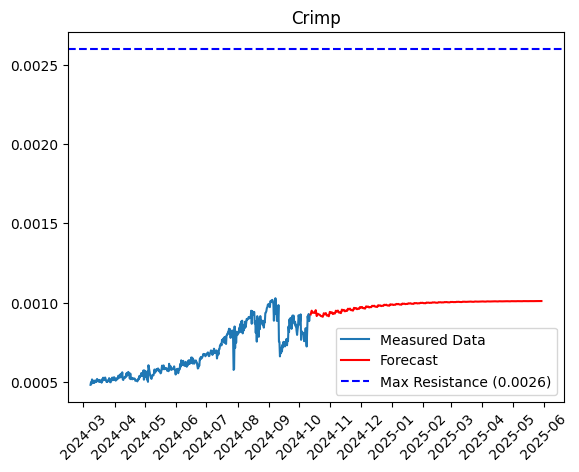

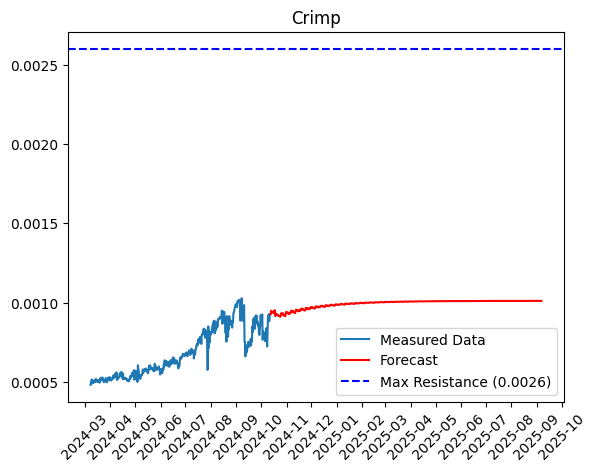

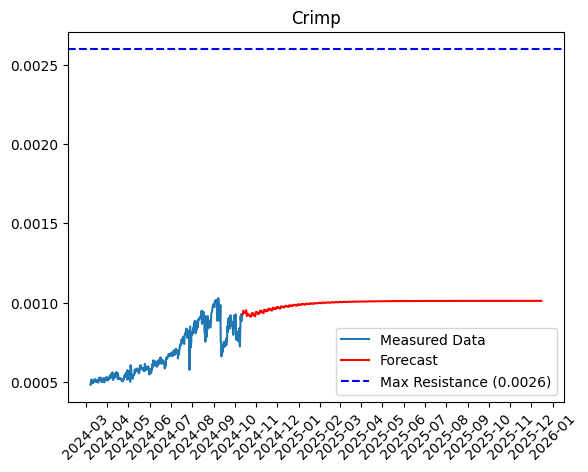

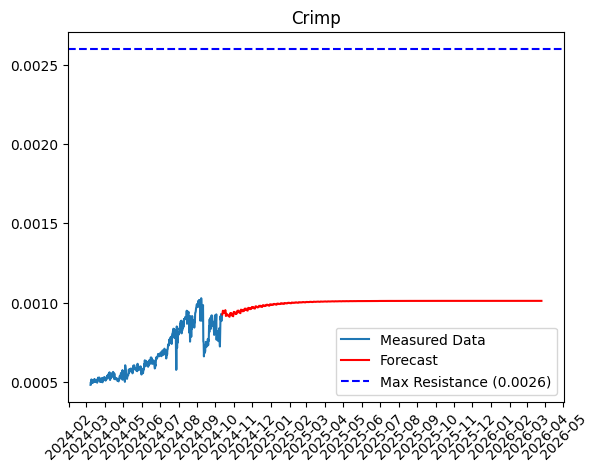

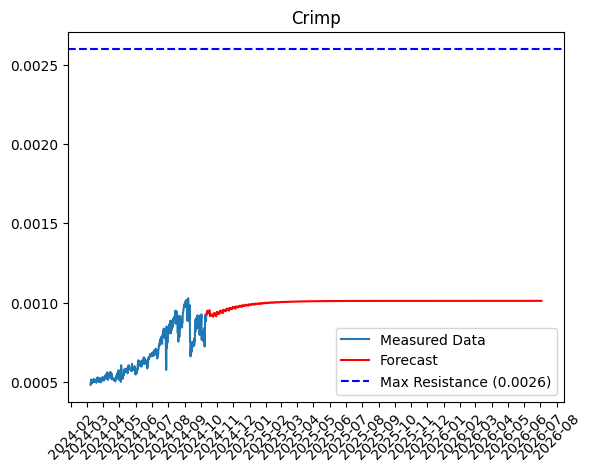

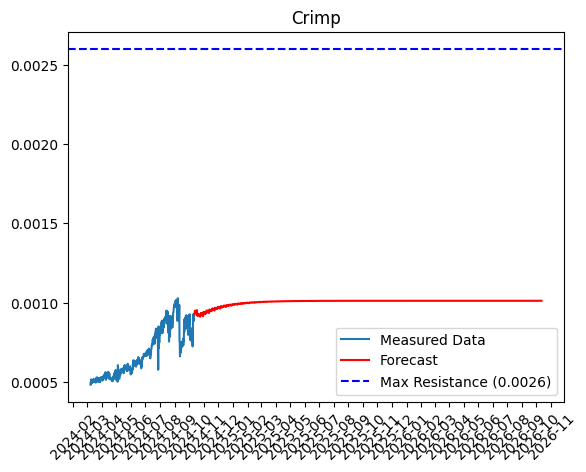

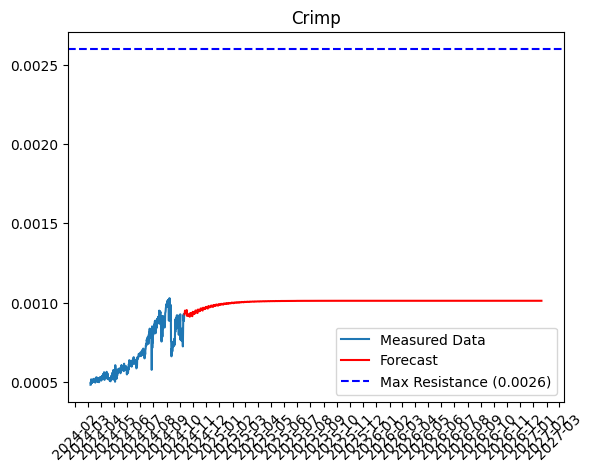

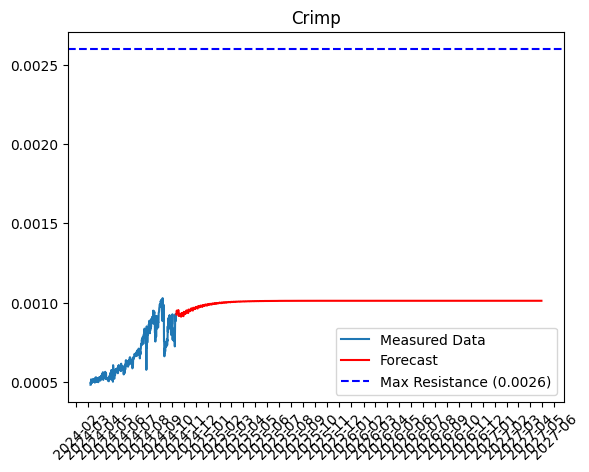

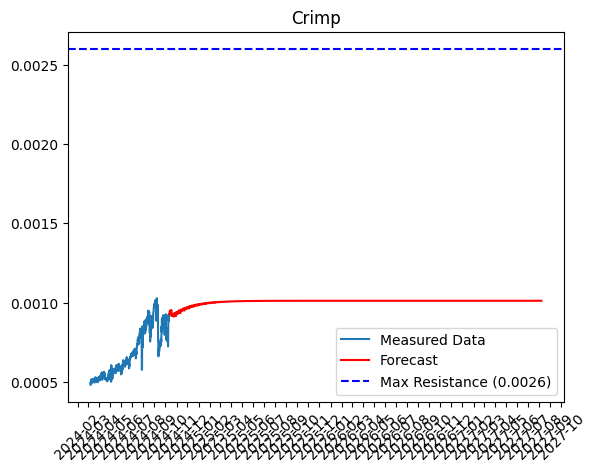

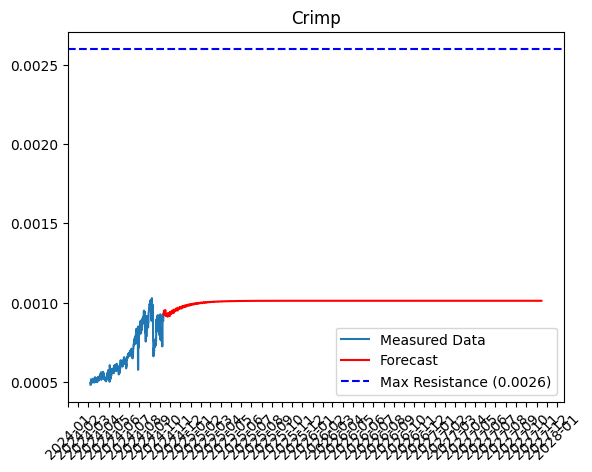

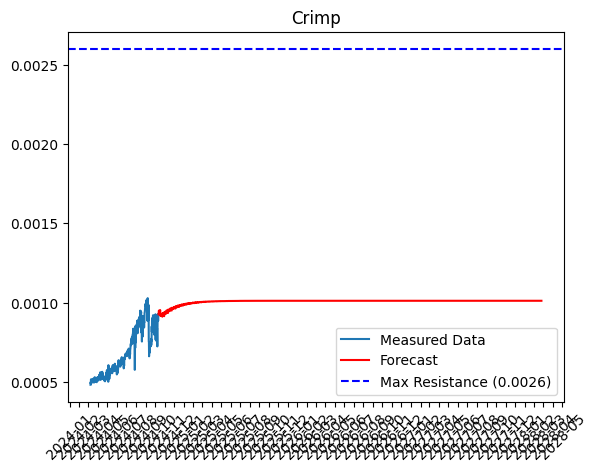

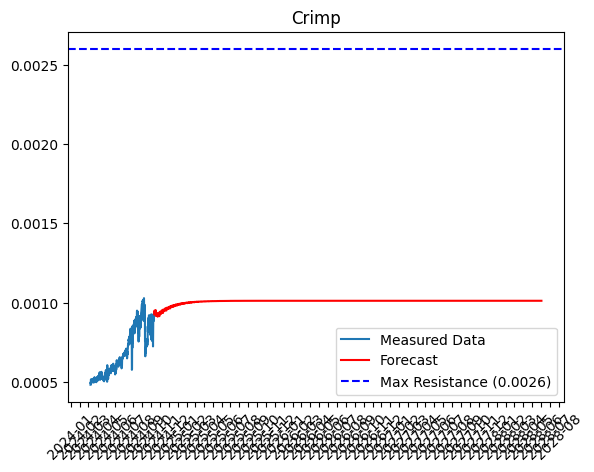

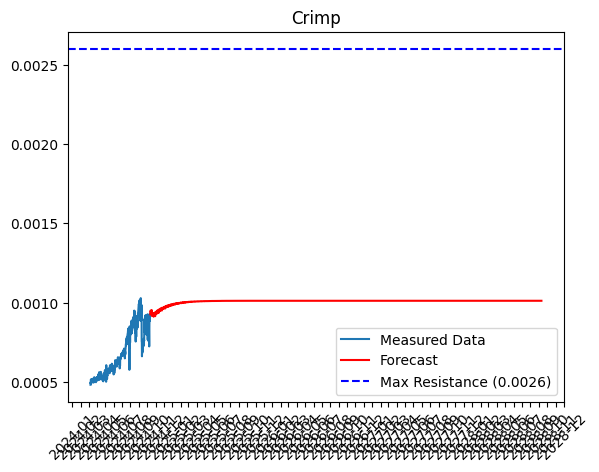

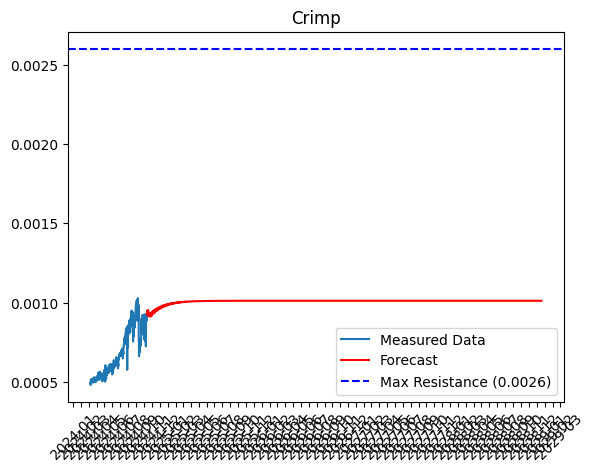

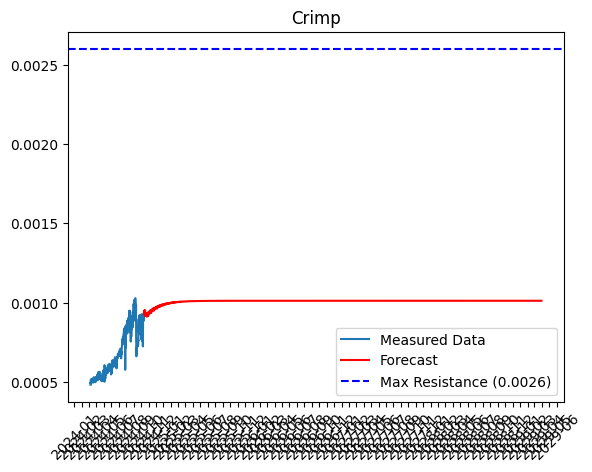

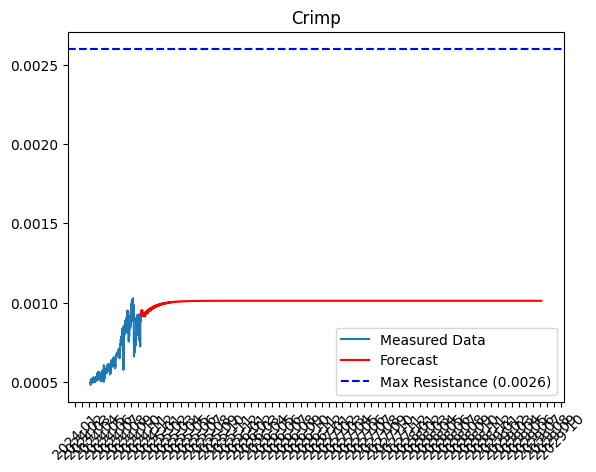

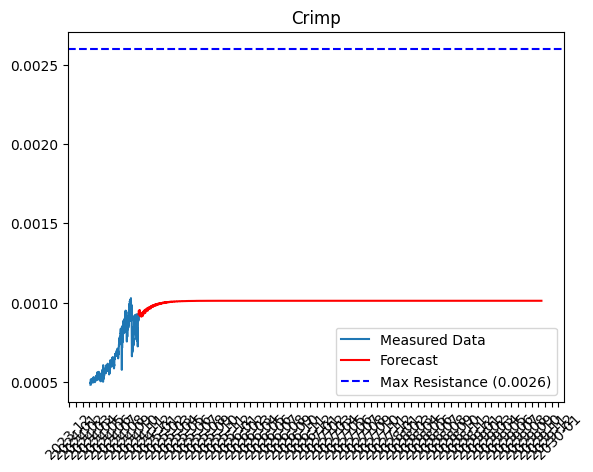

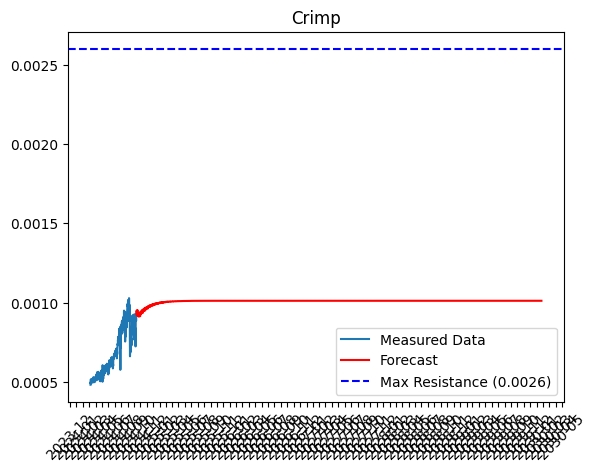

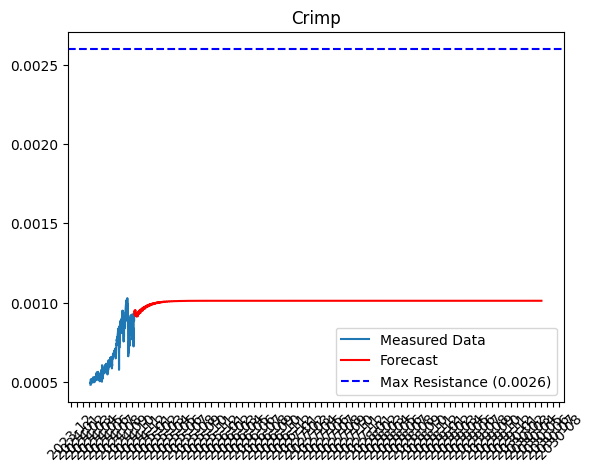

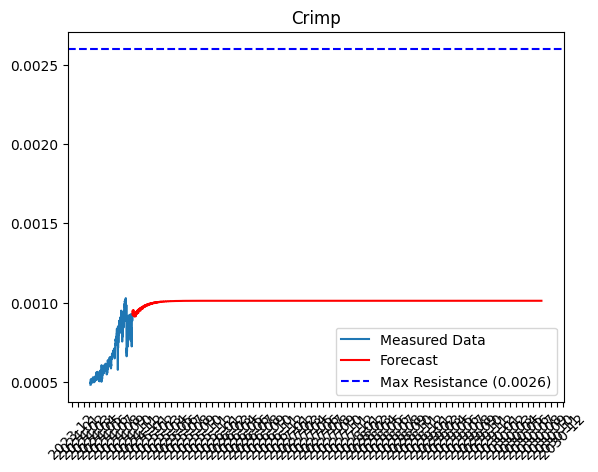

KeyboardInterrupt: 

In [171]:
forecast_steps = 30
max_resistance = 0.0026

while forecast_mean_original_crimp[-1] < max_resistance:
    forecast = results_SARIMA_crimp.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=0.05)

    forecast_index = pd.date_range(start=ts_resampled_crimp.index[-1], periods=forecast_steps+1, freq='D')[1:]

    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index

    forecast_mean_original = np.exp(forecast_mean)
    forecast_ci_original = np.exp(forecast_ci)
    forecast_steps += 100

    plt.title('Crimp')
    plt.plot(ts_resampled_crimp.index, ts_resampled_crimp, label='Measured Data')
    plt.plot(forecast_mean_original.index, forecast_mean_original, color='red', label='Forecast')
    plt.axhline(y=max_resistance, color='blue', linestyle='--', linewidth=1.5, label='Max Resistance (0.0026)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

print(f"The date when the resistance level of {max_resistance} is reached is {forecast_mean_original.index[-1]}")

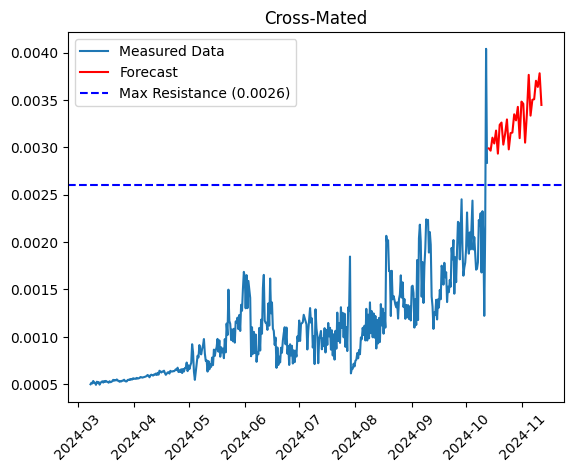

The date when the resistance level of 0.0026 is reached is 2024-11-11 12:00:00


In [168]:
forecast_steps = 30
max_resistance = 0.0026

# Initialize empty containers for the extended forecast
forecast_mean_original_cross = []
forecast_ci_original_cross = []

while True:
    # Generate forecast
    forecast = results_SARIMA_cross.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=0.05)

    # Transform forecasted values back to the original scale
    forecast_mean_original = np.exp(forecast_mean)
    forecast_ci_original = np.exp(forecast_ci)

    # Extend the forecast index
    forecast_index = pd.date_range(start=ts_resampled_cross.index[-1], periods=forecast_steps + 1, freq='D')[1:]
    forecast_mean_original.index = forecast_index
    forecast_ci_original.index = forecast_index

    # Append forecast results to the extended containers
    if not forecast_mean_original_cross:
        forecast_mean_original_cross = forecast_mean_original
        forecast_ci_original_cross = forecast_ci_original
    else:
        forecast_mean_original_cross = forecast_mean_original_cross.append(forecast_mean_original)
        forecast_ci_original_cross = forecast_ci_original_cross.append(forecast_ci_original)

    # Check if the resistance level is reached
    if forecast_mean_original_cross[-1] >= max_resistance:
        break

    # Increment the forecast steps for the next iteration
    forecast_steps += 100

# Plot the results
plt.title('Cross-Mated')
plt.plot(ts_resampled_cross.index, ts_resampled_cross, label='Measured Data')
plt.plot(forecast_mean_original_cross.index, forecast_mean_original_cross, color='red', label='Forecast')
plt.axhline(y=max_resistance, color='blue', linestyle='--', linewidth=1.5, label='Max Resistance (0.0026)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(f"The date when the resistance level of {max_resistance} is reached is {forecast_mean_original_cross.index[-1]}")
